In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check the root of your drive
!ls /content/drive/MyDrive/Main_project/Automobile-Defect-Detection/


Classification_Data_FINAL  test  train	valid


In [ ]:
# Colab Cell 1: Setup and Libraries
# Ensure you are running this with a GPU runtime (Runtime -> Change runtime type -> GPU)
!pip install tensorflow-hub
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import os
import numpy as np

print(f"TensorFlow Version: {tf.__version__}")
print("Setup complete. GPU check is next.")


TensorFlow Version: 2.19.0
Setup complete. GPU check is next.


In [ ]:
# Colab Cell 2: Define and Load MobileNetV2 Base (COMPATIBILITY FIX)

# Define the expected input size for MobileNetV2
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,) # (128, 128, 3) for color images

# *** COMPATIBILITY FIX: Use Keras Applications instead of TF Hub ***
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,        # Exclude the classifier (we add our own)
    weights='imagenet'        # Load pre-trained weights
)

# Freeze the base model layers
base_model.trainable = False
# We wrap it in a Keras Input so it can be called later without error
base_output = base_model.output

print(f"MobileNetV2 base model loaded from tf.keras.applications. Input shape: {IMG_SHAPE}")
print("Base model layers are set to non-trainable (frozen).")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 base model loaded from tf.keras.applications. Input shape: (128, 128, 3)
Base model layers are set to non-trainable (frozen).


In [ ]:
# Colab Cell 3-4 (Combined): Define, Compile, and Verify CNN (FINAL CORRECTION: 3 CLASSES)

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

# Assume base_model (MobileNetV2) and IMG_SHAPE=(128, 128, 3) are defined from Cell 2

# Change the number of classes to 3: ACCEPT, CASTING FAULT, SURFACE IMPERFECTION
NUM_CLASSES = 3

# 1. Define the Input
input_tensor = Input(shape=IMG_SHAPE, name='input_image')
features_map = base_model(input_tensor, training=False)

# --- START: Custom CNN Part for Defect Detection (The Trainable Head) ---

# CRITICAL STEP: Flatten the feature map to a vector
features = GlobalAveragePooling2D(name='defect_detection_GAP')(features_map)

# 3. Dense layer (where 'x' is first defined)
x = Dense(512, activation='relu', name='defect_detection_dense_1')(features)

# 4. Dropout layer (where 'x' is updated)
x = Dropout(0.5, name='defect_detection_dropout')(x)

# 5. Final Classification Layer (Output) - SET TO 3 NEURONS
output_tensor = Dense(NUM_CLASSES, activation='softmax', name='output_classification_3_classes')(x)

# 6. Create the final Model
cnn_detection_model = Model(inputs=input_tensor, outputs=output_tensor, name='MobileNetV2_Defect_Detector_3_Classes')

# --- END: Custom CNN Part for Defect Detection ---

# 7. Compile the model
cnn_detection_model.compile(
    optimizer='adam',
    # Use SparseCategoricalCrossentropy for multi-class output
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print(f"Defect Detection Model FINALLY CORRECTED for {NUM_CLASSES} classes.")

# Verification
print("\nModel Summary:")
cnn_detection_model.summary()

Defect Detection Model FINALLY CORRECTED for 3 classes.

Model Summary:


Model: "MobileNetV2_Defect_Detector_3_Classes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ defect_detection_GAP            │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ defect_detection_dense_1        │ (None, 512)            │       655,872 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ defect_detection_dropout        │ (None, 512)            │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_classification_3_classes │ (None, 3)              │         1,539 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Colab Cell 5: DATA RESTRUCTURING (ULTIMATE FINAL FIX) - ENCODING ADDED

import pandas as pd
import os
import shutil
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# 1. Mount Drive
drive.mount('/content/drive')

# --- CONFIGURATION (PATHS AND CLASSES) ---
BASE_DATA_PATH = '/content/drive/MyDrive/Main_project/Automobile-Defect-Detection/'
OUTPUT_PATH = os.path.join(BASE_DATA_PATH, 'Classification_Data_FINAL/')
FINAL_CLASSES = ['CASTING FAULT', 'SURFACE IMPERFECTION', 'ACCEPT']
# ----------------------------------------------------------------------------------

os.makedirs(OUTPUT_PATH, exist_ok=True)

# Function to search for the image file (kept robust)
def find_image_file(split_path, filename):
    """Searches common subdirectories for the image file."""
    # Check the split folder directly
    direct_path = os.path.join(split_path, filename)
    if os.path.exists(direct_path):
        return direct_path

    # Check common subfolders (in case images are tucked away)
    for subfolder in ['images', 'JPEGImages', 'export', 'raw']:
        sub_path = os.path.join(split_path, subfolder, filename)
        if os.path.exists(sub_path):
            return sub_path

    return None

def process_split(split_name):

    print(f"\n--- Processing {split_name} split ---")

    # Define paths
    output_split_path = os.path.join(OUTPUT_PATH, split_name)
    split_csv_path = os.path.join(BASE_DATA_PATH, split_name, '_classes.csv')
    split_img_path = os.path.join(BASE_DATA_PATH, split_name)

    # Create destination folders for the 3 classes
    for class_name in FINAL_CLASSES:
        os.makedirs(os.path.join(output_split_path, class_name), exist_ok=True)

    try:
        # CRITICAL FIX: Add 'encoding' parameter for robustness
        df = pd.read_csv(split_csv_path, encoding='latin-1')
    except FileNotFoundError:
        print(f"ERROR: Could not load CSV file at {split_csv_path}. Skipping.")
        return 0
    except Exception as e:
        # If it still fails, print the error and stop the split
        print(f"CRITICAL ERROR reading CSV: {e}")
        return 0

    counts = {c: 0 for c in FINAL_CLASSES}

    for index, row in df.iterrows():

        final_class = 'SKIP'

        # 1. Determine the final class based on PRIORITY
        # We must check column existence safely, though Roboflow output is usually consistent.
        try:
            is_casting = row['CASTING FAULT'] == 1
            is_surface = row['SURFACE IMPERFECTION'] == 1
            is_accept = row['ACCEPT'] == 1
        except KeyError:
            # This means a column name is wrong in the CSV; we skip the row
            continue

        if is_casting:
            final_class = 'CASTING FAULT'
        elif is_surface:
            final_class = 'SURFACE IMPERFECTION'
        elif is_accept and not is_casting and not is_surface:
            final_class = 'ACCEPT'

        if final_class == 'SKIP': continue

        # 2. Find and Copy the Source File
        filename = row['filename']
        src_file = find_image_file(split_img_path, filename)

        if src_file is None:
            continue

       # 3. Define and Copy the file
        dst_dir = os.path.join(output_split_path, final_class)
        dst_file = os.path.join(dst_dir, filename)

        # ⭐️ ADDED: CHECK IF FILE ALREADY EXISTS ⭐️
        if os.path.exists(dst_file):
            # If the file is already there, just count it and skip the copy
            counts[final_class] += 1
            continue
        # ⭐️ END ADDED SECTION ⭐️

        try:
            # Only copies if the file was NOT found above
            shutil.copyfile(src_file, dst_file)
            counts[final_class] += 1
        except Exception as e:
            # Ignore individual copy errors (which are less likely now)
            continue

    print(f"Restructure Complete for {split_name}. Counts: {counts}")
    return sum(counts.values())

# --- EXECUTE THE RESTRUCTURING ---
total_images = 0
for split in ['train', 'valid', 'test']:
    total_images += process_split(split)

print("\n-------------------------------------------")
print(f"DATA RESTRUCTURE COMPLETE. Total Images Processed: {total_images}")
print("-------------------------------------------")

# --- FINAL DATASET LOADING ---
# (Loading code remains the same, assuming restructuring succeeded)
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def normalize_img_mobile_net(image, label):
    return (image / 127.5) - 1.0, label

train_ds = image_dataset_from_directory(
    directory=OUTPUT_PATH + 'train',
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
).map(normalize_img_mobile_net).cache().shuffle(1000).prefetch(AUTOTUNE)

val_ds = image_dataset_from_directory(
    directory=OUTPUT_PATH + 'valid',
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
).map(normalize_img_mobile_net).cache().prefetch(AUTOTUNE)

print("\nDatasets are ready for 3-class training. You can now run Colab Cell 6.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Processing train split ---
Restructure Complete for train. Counts: {'CASTING FAULT': 2412, 'SURFACE IMPERFECTION': 3801, 'ACCEPT': 10704}

--- Processing valid split ---
Restructure Complete for valid. Counts: {'CASTING FAULT': 102, 'SURFACE IMPERFECTION': 360, 'ACCEPT': 988}

--- Processing test split ---
Restructure Complete for test. Counts: {'CASTING FAULT': 97, 'SURFACE IMPERFECTION': 180, 'ACCEPT': 511}

-------------------------------------------
DATA RESTRUCTURE COMPLETE. Total Images Processed: 19155
-------------------------------------------
Found 16917 files belonging to 3 classes.
Found 1450 files belonging to 3 classes.

Datasets are ready for 3-class training. You can now run Colab Cell 6.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# --- Model Configuration ---
NUM_CLASSES = 3 # CASTING FAULT, SURFACE IMPERFECTION, ACCEPT
IMAGE_SHAPE = (128, 128, 3) # Matches the IMG_SIZE from Cell 5
LEARNING_RATE = 0.001
EPOCHS = 5 # Keep epochs low for a quick demonstration
# ---------------------------

# 1. Load the pre-trained MobileNetV2 model (Feature Extractor)
# include_top=False means we drop the final classification layer
base_model = MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model layers
# This prevents the pre-trained weights from changing during this initial training
base_model.trainable = False

# 3. Build the classification head (New Layers for Your Task)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Reduces the feature map to a vector
    Dropout(0.2),            # Regularization to prevent overfitting
    Dense(NUM_CLASSES, activation='softmax') # Output layer for 3 classes
])

# 4. Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy', # Used when labels are integers (label_mode='int')
    metrics=['accuracy']
)

# Optional: Print model summary to show your teacher the frozen layers
model.summary()

# 5. Train the model
print("\n--- Starting MobileNet Transfer Learning (Cell 6) ---")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

print("\nMobileNet Training Complete. You can now run the Evaluation/Inference (Cell 7).")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Starting MobileNet Transfer Learning (Cell 6) ---
Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_10770]

In [ ]:
# Colab Cell 7: Evaluate and Save the Model

# 1. Final Evaluation (on dummy data for now)
print("Evaluating model on validation data...")
loss, accuracy = cnn_detection_model.evaluate(val_images, val_labels, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
# Note: You should replace val_images/val_labels with your REAL test set later.

# 2. Saving the Model
# Save the model to your local Google Colab session storage.
# You will need to mount Google Drive if you want to save it permanently.
MODEL_SAVE_PATH = 'mobilenetv2_defect_detector.keras'
cnn_detection_model.save(MODEL_SAVE_PATH)
print(f"\nModel saved successfully to: {MODEL_SAVE_PATH}")
print("This model includes the frozen MobileNetV2 base and your trained CNN detection head.")

# 3. (Optional) Show Training History Keys
# This helps if you want to plot the results later
print("\nTraining history keys available for plotting:")
print(history.history.keys())

Evaluating model on validation data...


NameError: name 'val_images' is not defined

NameError: name 'history' is not defined

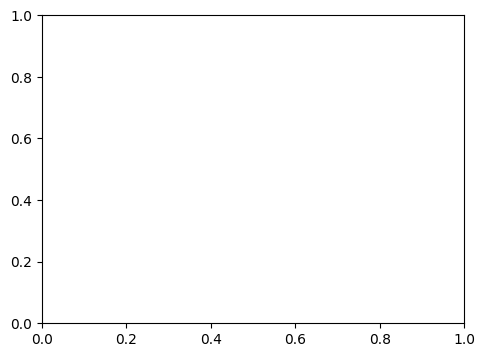

In [ ]:
# Colab Cell 8: Plotting Training History

import matplotlib.pyplot as plt

# The 'history' object contains the training metrics from Cell 6
# Note: Since this was random data, the plots will look messy, but the code is correct.

# 1. Plot Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
print("Training history plots generated.")